# Visualizing the output of sourmash taxonomy using metacoder heat trees

[Metacoder](https://grunwaldlab.github.io/metacoder_documentation/index.html) is an R package for visualizing heat trees from taxonomic data. 
This notebook parses the output of `sourmash taxonomy` to produce plots that show:
1. the taxonomic composition of all samples
2. the taxonomic composition of all samples, colored by the lineages present in a single sample
3. the taxonomic composition of all samples, agglomerated to a higher level of taxonomy (e.g. genus instead of strain).

In [1]:
setwd("..")

In [18]:
# adjust plot size rendered inline
options(repr.plot.width = 9, repr.plot.height = 8, repr.plot.res = 200)

In [17]:
library(tidyverse)
library(metacoder)

## Read in sourmash taxonomy results and format

In [4]:
# read in the sourmash taxonomy results from all samples into a single data frame
sourmash_taxonomy_results <- Sys.glob("outputs/sourmash_taxonomy/*genbank-2022.03-k31.with-lineages.csv") %>%
  map_dfr(read_csv, col_types = "ddddddddcccddddcccdc") %>% # read in all of the taxonomy results
  mutate(name = gsub(" .*", "", name)) %>% # simplify the genome name to only include the accession
  mutate(n_unique_kmers = (unique_intersect_bp / scaled) * average_abund) # calculate the number of uniquely matched k-mers

In [5]:
# change sourmash_taxonomy_results to wide format
sourmash_taxonomy_results_wide <- sourmash_taxonomy_results %>%
  select(name, lineage, query_name, n_unique_kmers) %>%
  pivot_wider(id_cols = name:lineage, names_from = query_name, values_from = n_unique_kmers)

## Make the metacoder object and calculate information up the taxonomic lineage

In [6]:
# parse the taxonomy results into a metacoder object
obj <- parse_tax_data(sourmash_taxonomy_results_wide,
                      class_cols = "lineage", # the column that contains taxonomic information
                      class_sep = ";", # The character used to separate taxa in the classification
                      class_regex = "(.*)", # Regex identifying where the data for each taxon is
                      class_key = c(tax_name = "taxon_name")) # A key describing each regex capture group

In [7]:
# set number of unique k-mers assigned to a genome as the abundance information
obj$data$tax_abund <- calc_taxon_abund(obj, "tax_data", cols = unique(sourmash_taxonomy_results$query_name))

Summing per-taxon counts from 6 columns for 2762 taxa



In [8]:
# calc_n_samples() calculates the number of samples that contained a taxonomic lineage, 
# and propagates that information up the lineage.
# we can supply it with sample and group information. 
# the group information is used for adding color to the plots below.

# in this case, our samples don't actually have groups 
# (e.g. each sample represents its own group as it is one timepoint in a time series).
# we'll use the sample accessions as our groups, but we need to modify them so that metacoder 
# doesn't get confused between a group and a sample.
groups <- paste0("x", unique(sourmash_taxonomy_results$query_name))

obj$data$tax_occ <- calc_n_samples(obj, "tax_abund", 
                                   groups =  groups, 
                                   cols = unique(sourmash_taxonomy_results$query_name))

Calculating number of samples with a value greater than 0 for 6 columns in 6 groups for 2762 observations



## Plot heat tree up to strain level with lineages from all samples

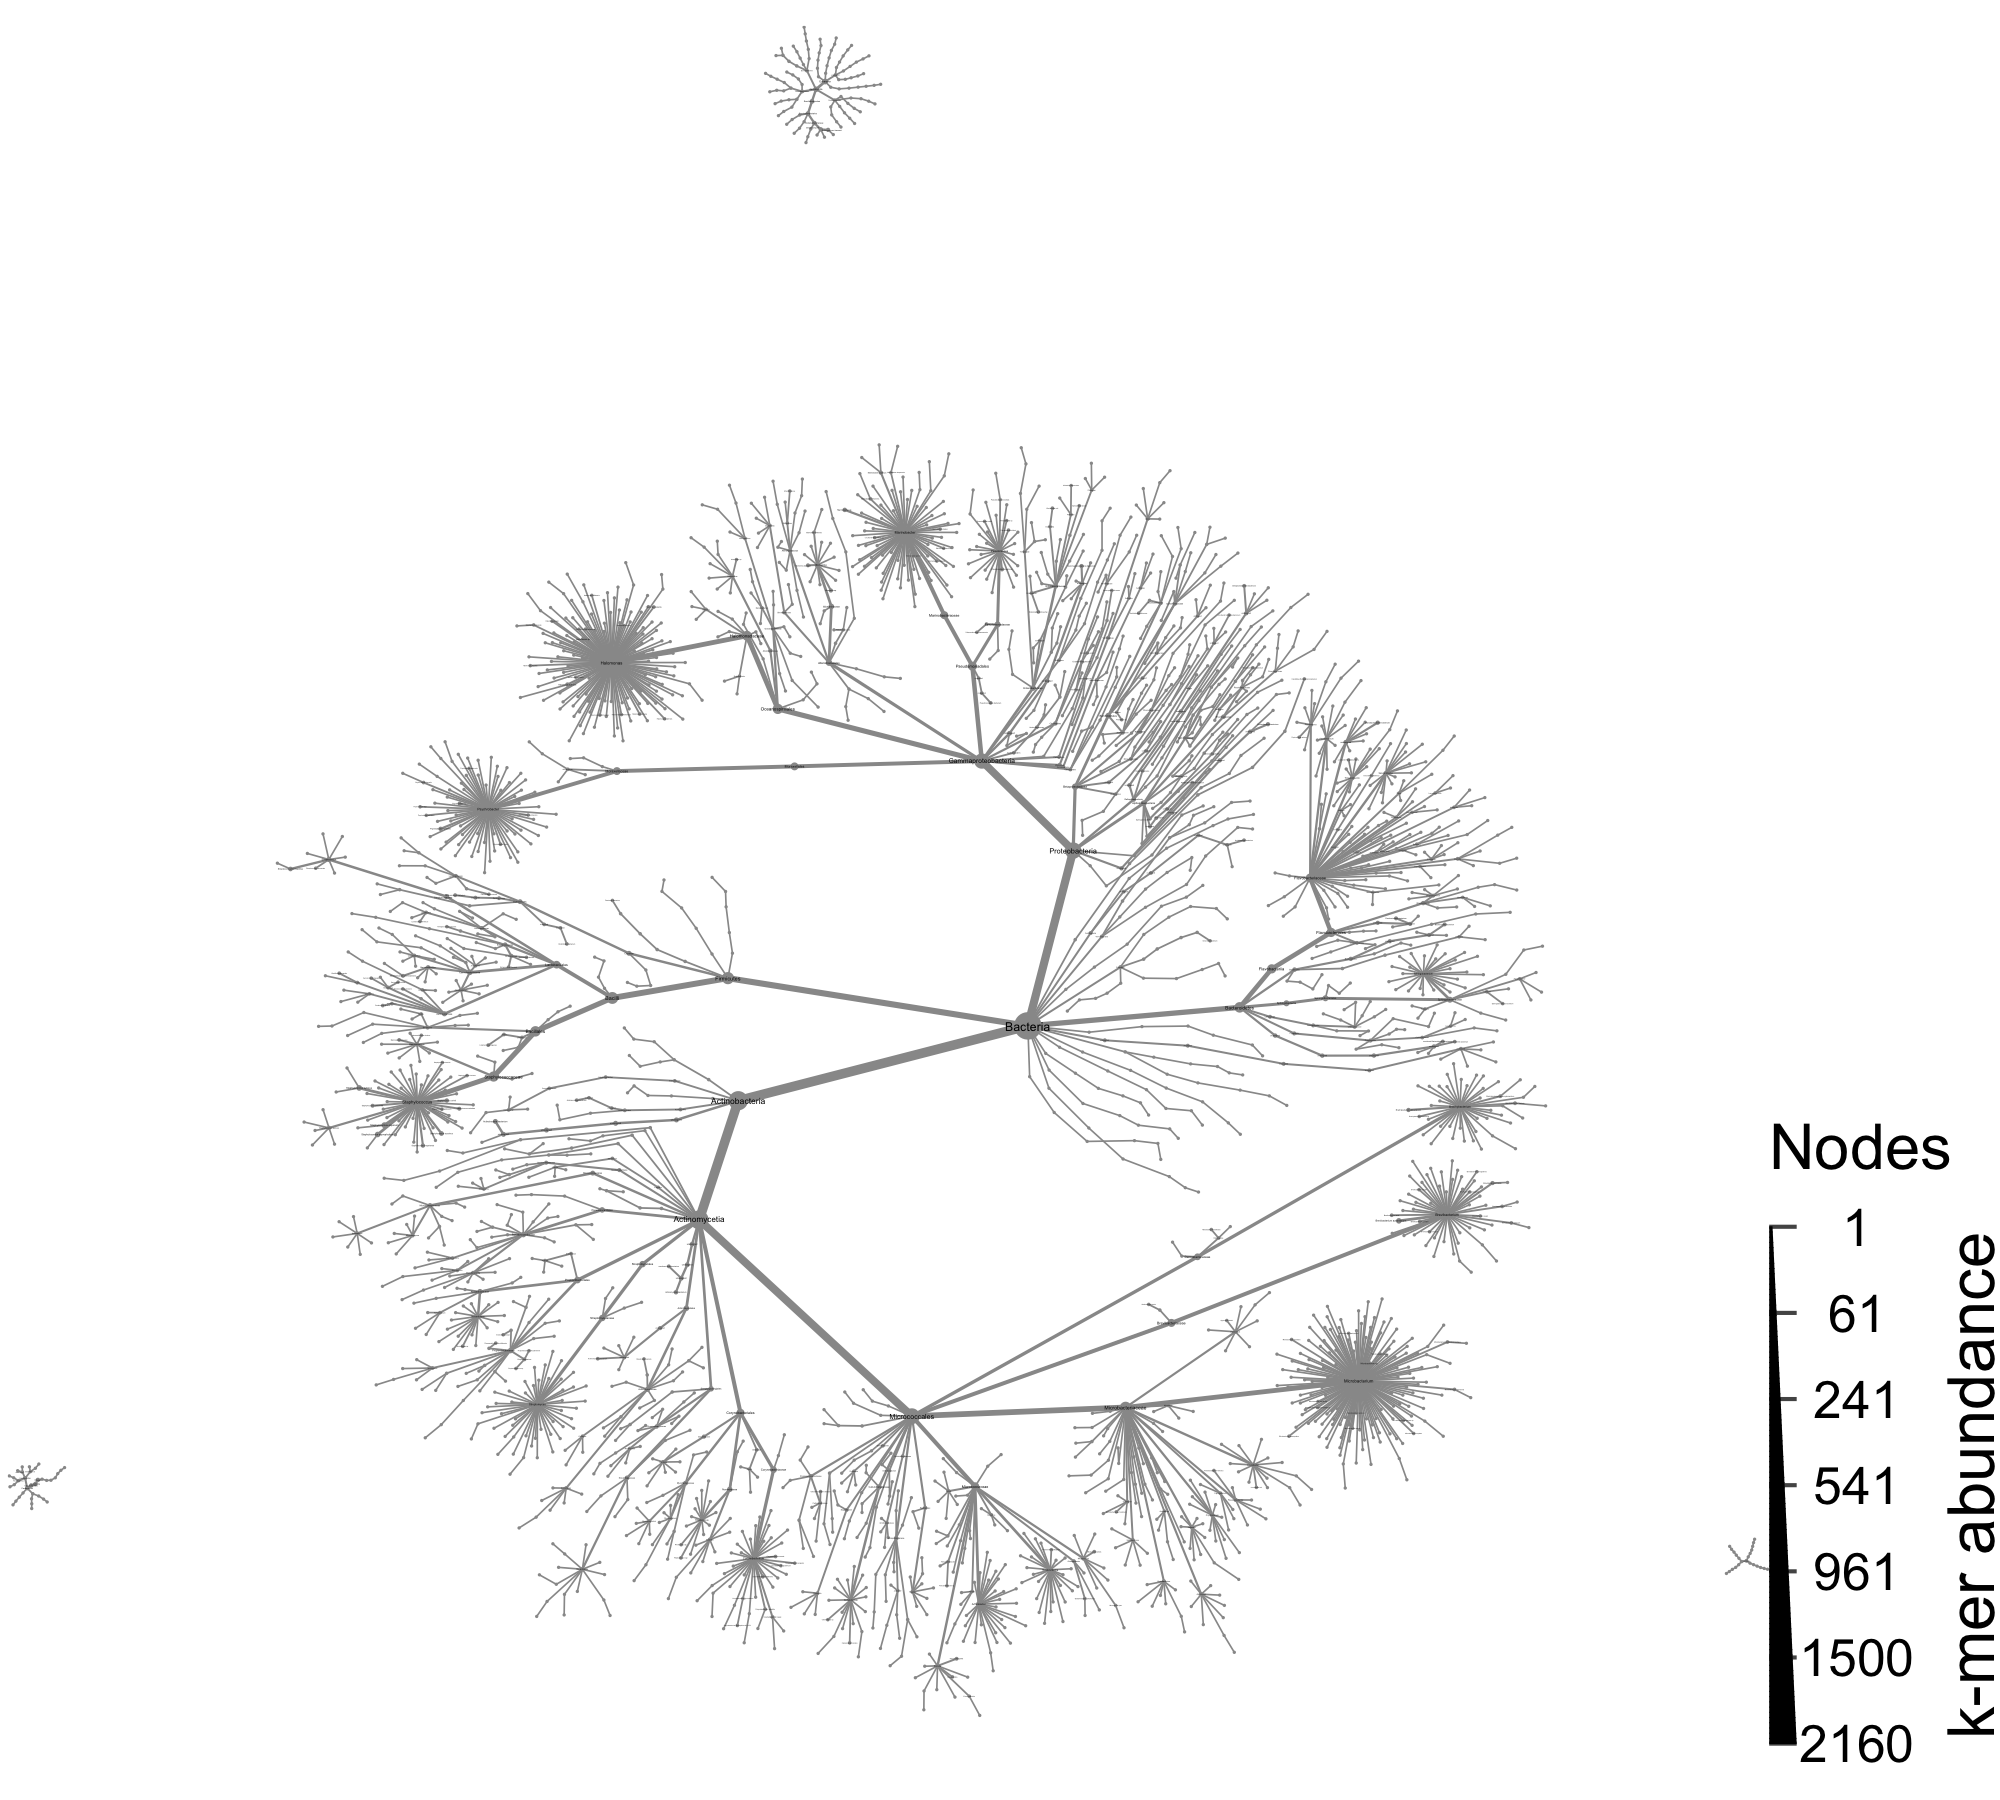

In [9]:
# generate a heat_tree plot with all taxa from all samples
set.seed(1) # This makes the plot appear the same each time it is run 
heat_tree(obj, 
          node_label = taxon_names,
          node_size = n_obs,
          node_size_axis_label = "k-mer abundance",
          #output_file = "metacoder_all.pdf", # uncomment to save file upon running
          layout = "davidson-harel", # The primary layout algorithm
          initial_layout = "reingold-tilford") # The layout algorithm that initializes node locations

## Plot heat tree up to strain level with lineages from all samples but colored by lineages observed in only one samples

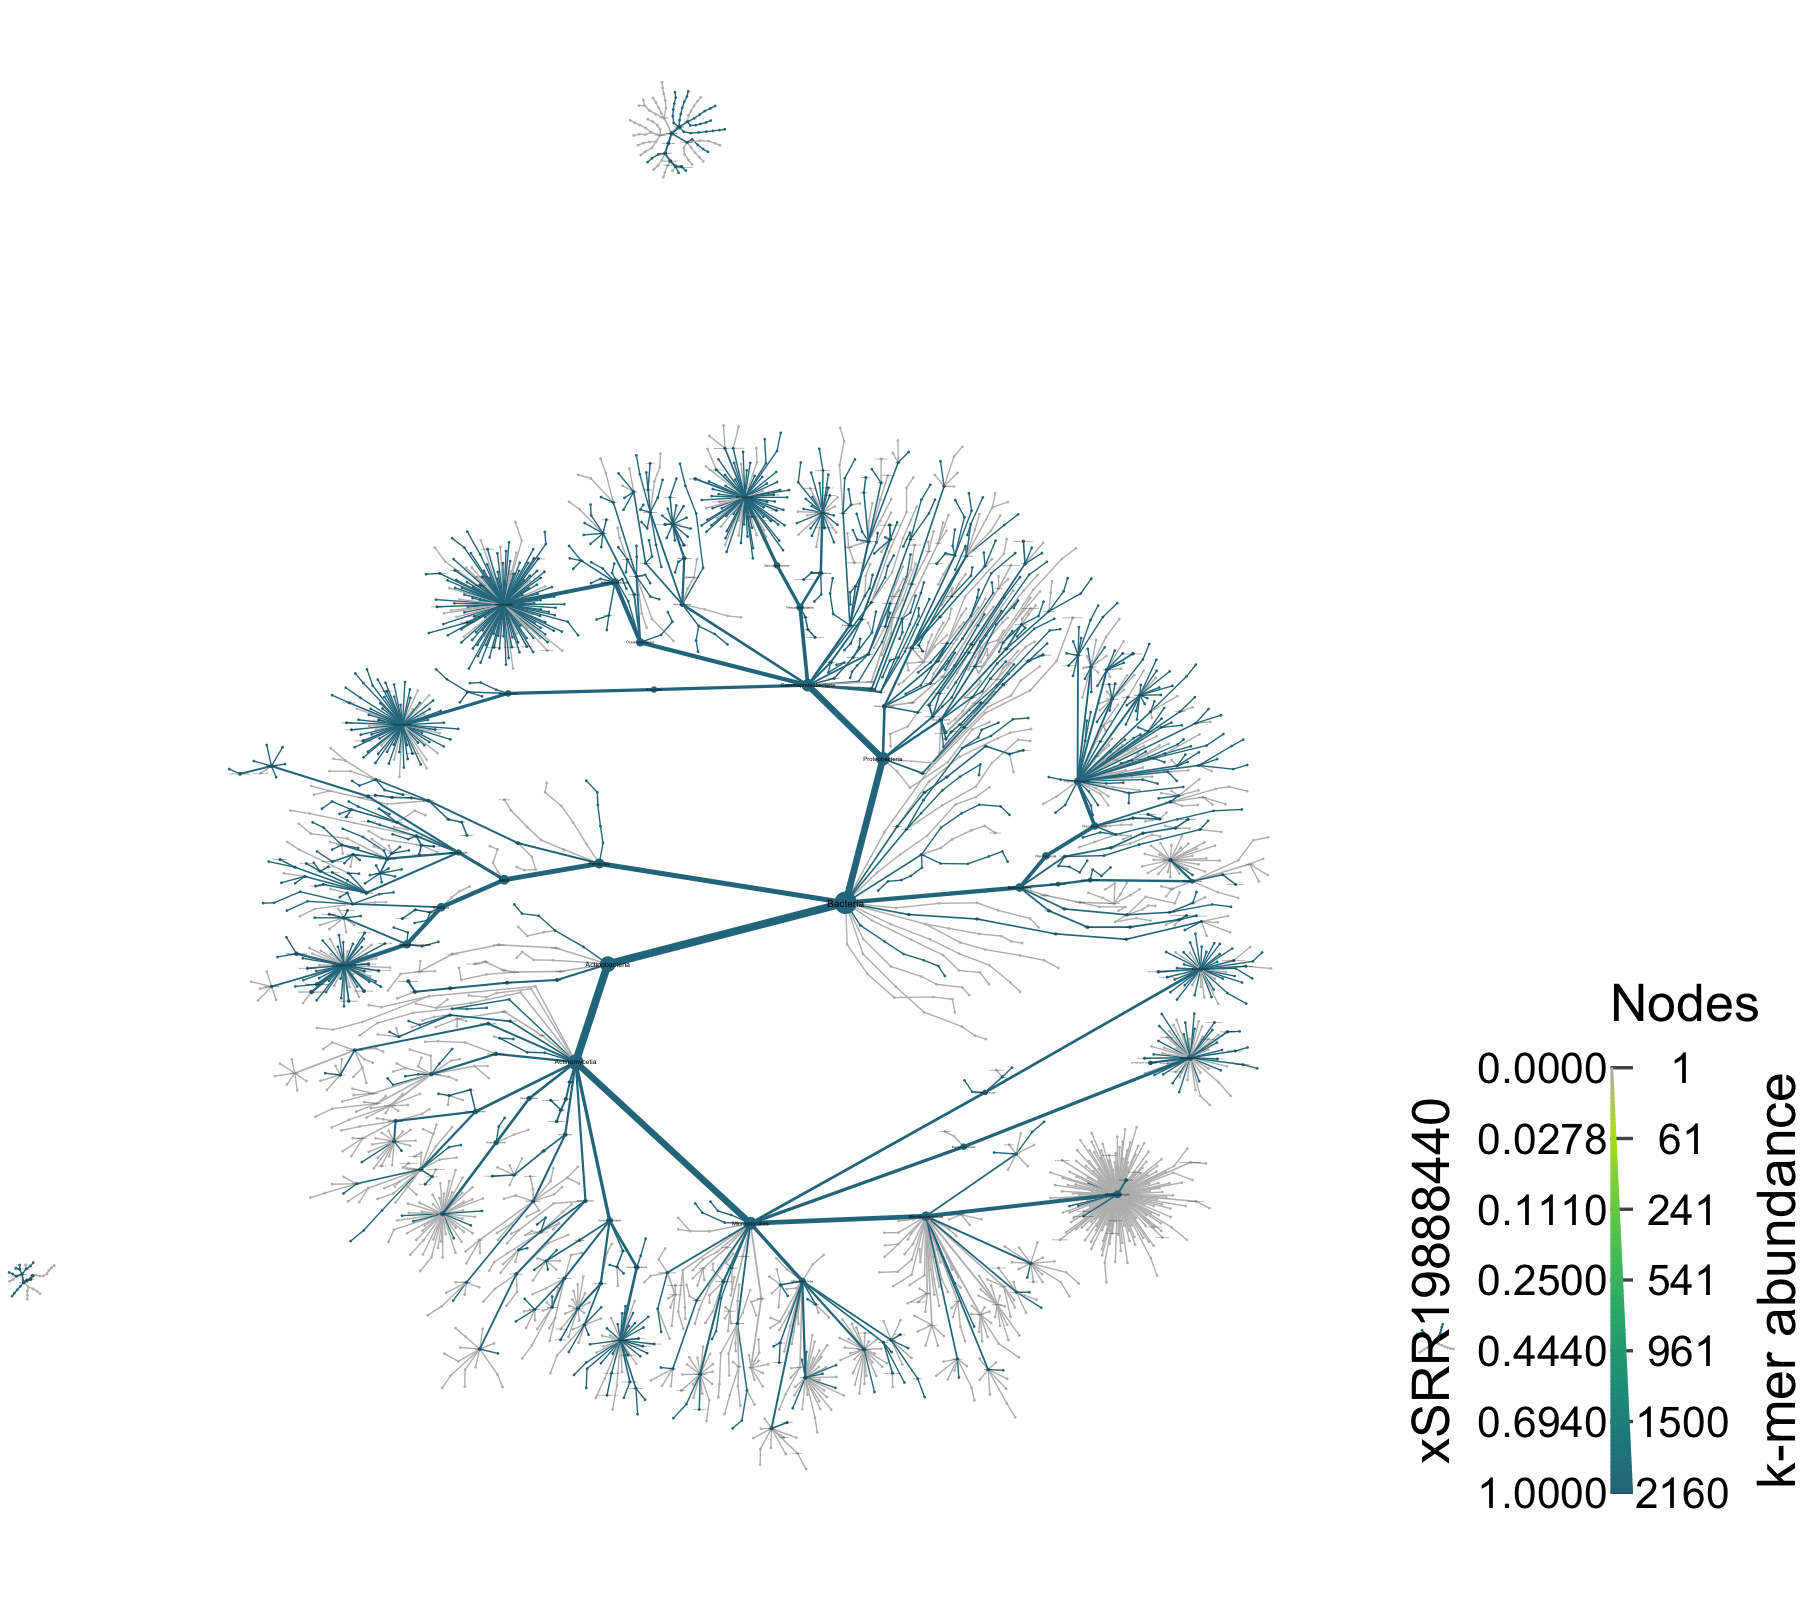

In [19]:
# generate a heat_tree plot with all taxa from all samples, but colored by taxa that were present in an individual sample
set.seed(1) # This makes the plot appear the same each time it is run 
heat_tree(obj, 
          node_label = taxon_names,
          node_size = n_obs,
          node_size_axis_label = "k-mer abundance",
          node_color = xSRR19888440,
          output_file = "metacoder_xSRR19888440.pdf", # uncomment to save file upon running
          layout = "davidson-harel", # The primary layout algorithm
          initial_layout = "reingold-tilford") # The layout algorithm that initializes node locations

## Agglomerating to higher levels of taxonomy (e.g. genus) to simplify the metacoder plot

The above plots show all of the distinct lineages we observed in all samples (plot 1), colored by a single sample (plot 2). 
Because these samples are so complex, it's difficult to visualize all lineages as once. 
The simplify visualization of all samples, we'll first agglomerate abundances to the genus level.
While we demonstrate this at the genus level, agglomeration could be performed at any level of taxonomy (e.g. family).

In [11]:
# The missing pieces come from lineages that don't have strain-level information (e.g. only info up to species)
sourmash_taxonomy_results_genus <- sourmash_taxonomy_results %>%
  select(name, lineage, query_name, n_unique_kmers) %>%
  separate(lineage, into = c("domain", "phylum", "class", "order", "family", "genus", "species", "strain"), sep = ";") %>%
  group_by(query_name, domain, phylum, class, order, family, genus) %>%
  summarize(n_unique_kmers = sum(n_unique_kmers)) %>%
  ungroup() %>%
  mutate(lineage = paste(domain, phylum, class, order, family, genus, sep = ";")) %>%
  select(lineage, query_name, n_unique_kmers)

Warning message:
“Expected 8 pieces. Missing pieces filled with `NA` in 4999 rows [1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, ...].”
`summarise()` has grouped output by 'query_name', 'domain', 'phylum', 'class', 'order', 'family'. You can override using the `.groups`
argument.


In [12]:
sourmash_taxonomy_results_genus_wide <- sourmash_taxonomy_results_genus %>%
  select(lineage, query_name, n_unique_kmers) %>%
  pivot_wider(id_cols = lineage, names_from = query_name, values_from = n_unique_kmers)

In [13]:
# parse the taxonomy results into a metacoder object
obj_genus <- parse_tax_data(sourmash_taxonomy_results_genus_wide,
                            class_cols = "lineage", # the column that contains taxonomic information
                            class_sep = ";", # The character used to separate taxa in the classification
                            class_regex = "(.*)", # Regex identifying where the data for each taxon is
                            class_key = c(tax_name = "taxon_name")) # A key describing each regex capture group

In [14]:
# set number of unique k-mers assigned to a genome as the abundance information
obj_genus$data$tax_abund <- calc_taxon_abund(obj_genus, "tax_data", cols = unique(sourmash_taxonomy_results$query_name))

Summing per-taxon counts from 6 columns for 925 taxa



In [15]:
obj_genus$data$tax_occ <- calc_n_samples(obj_genus, "tax_abund", 
                                         groups =  groups, 
                                         cols = unique(sourmash_taxonomy_results$query_name))

Calculating number of samples with a value greater than 0 for 6 columns in 6 groups for 925 observations



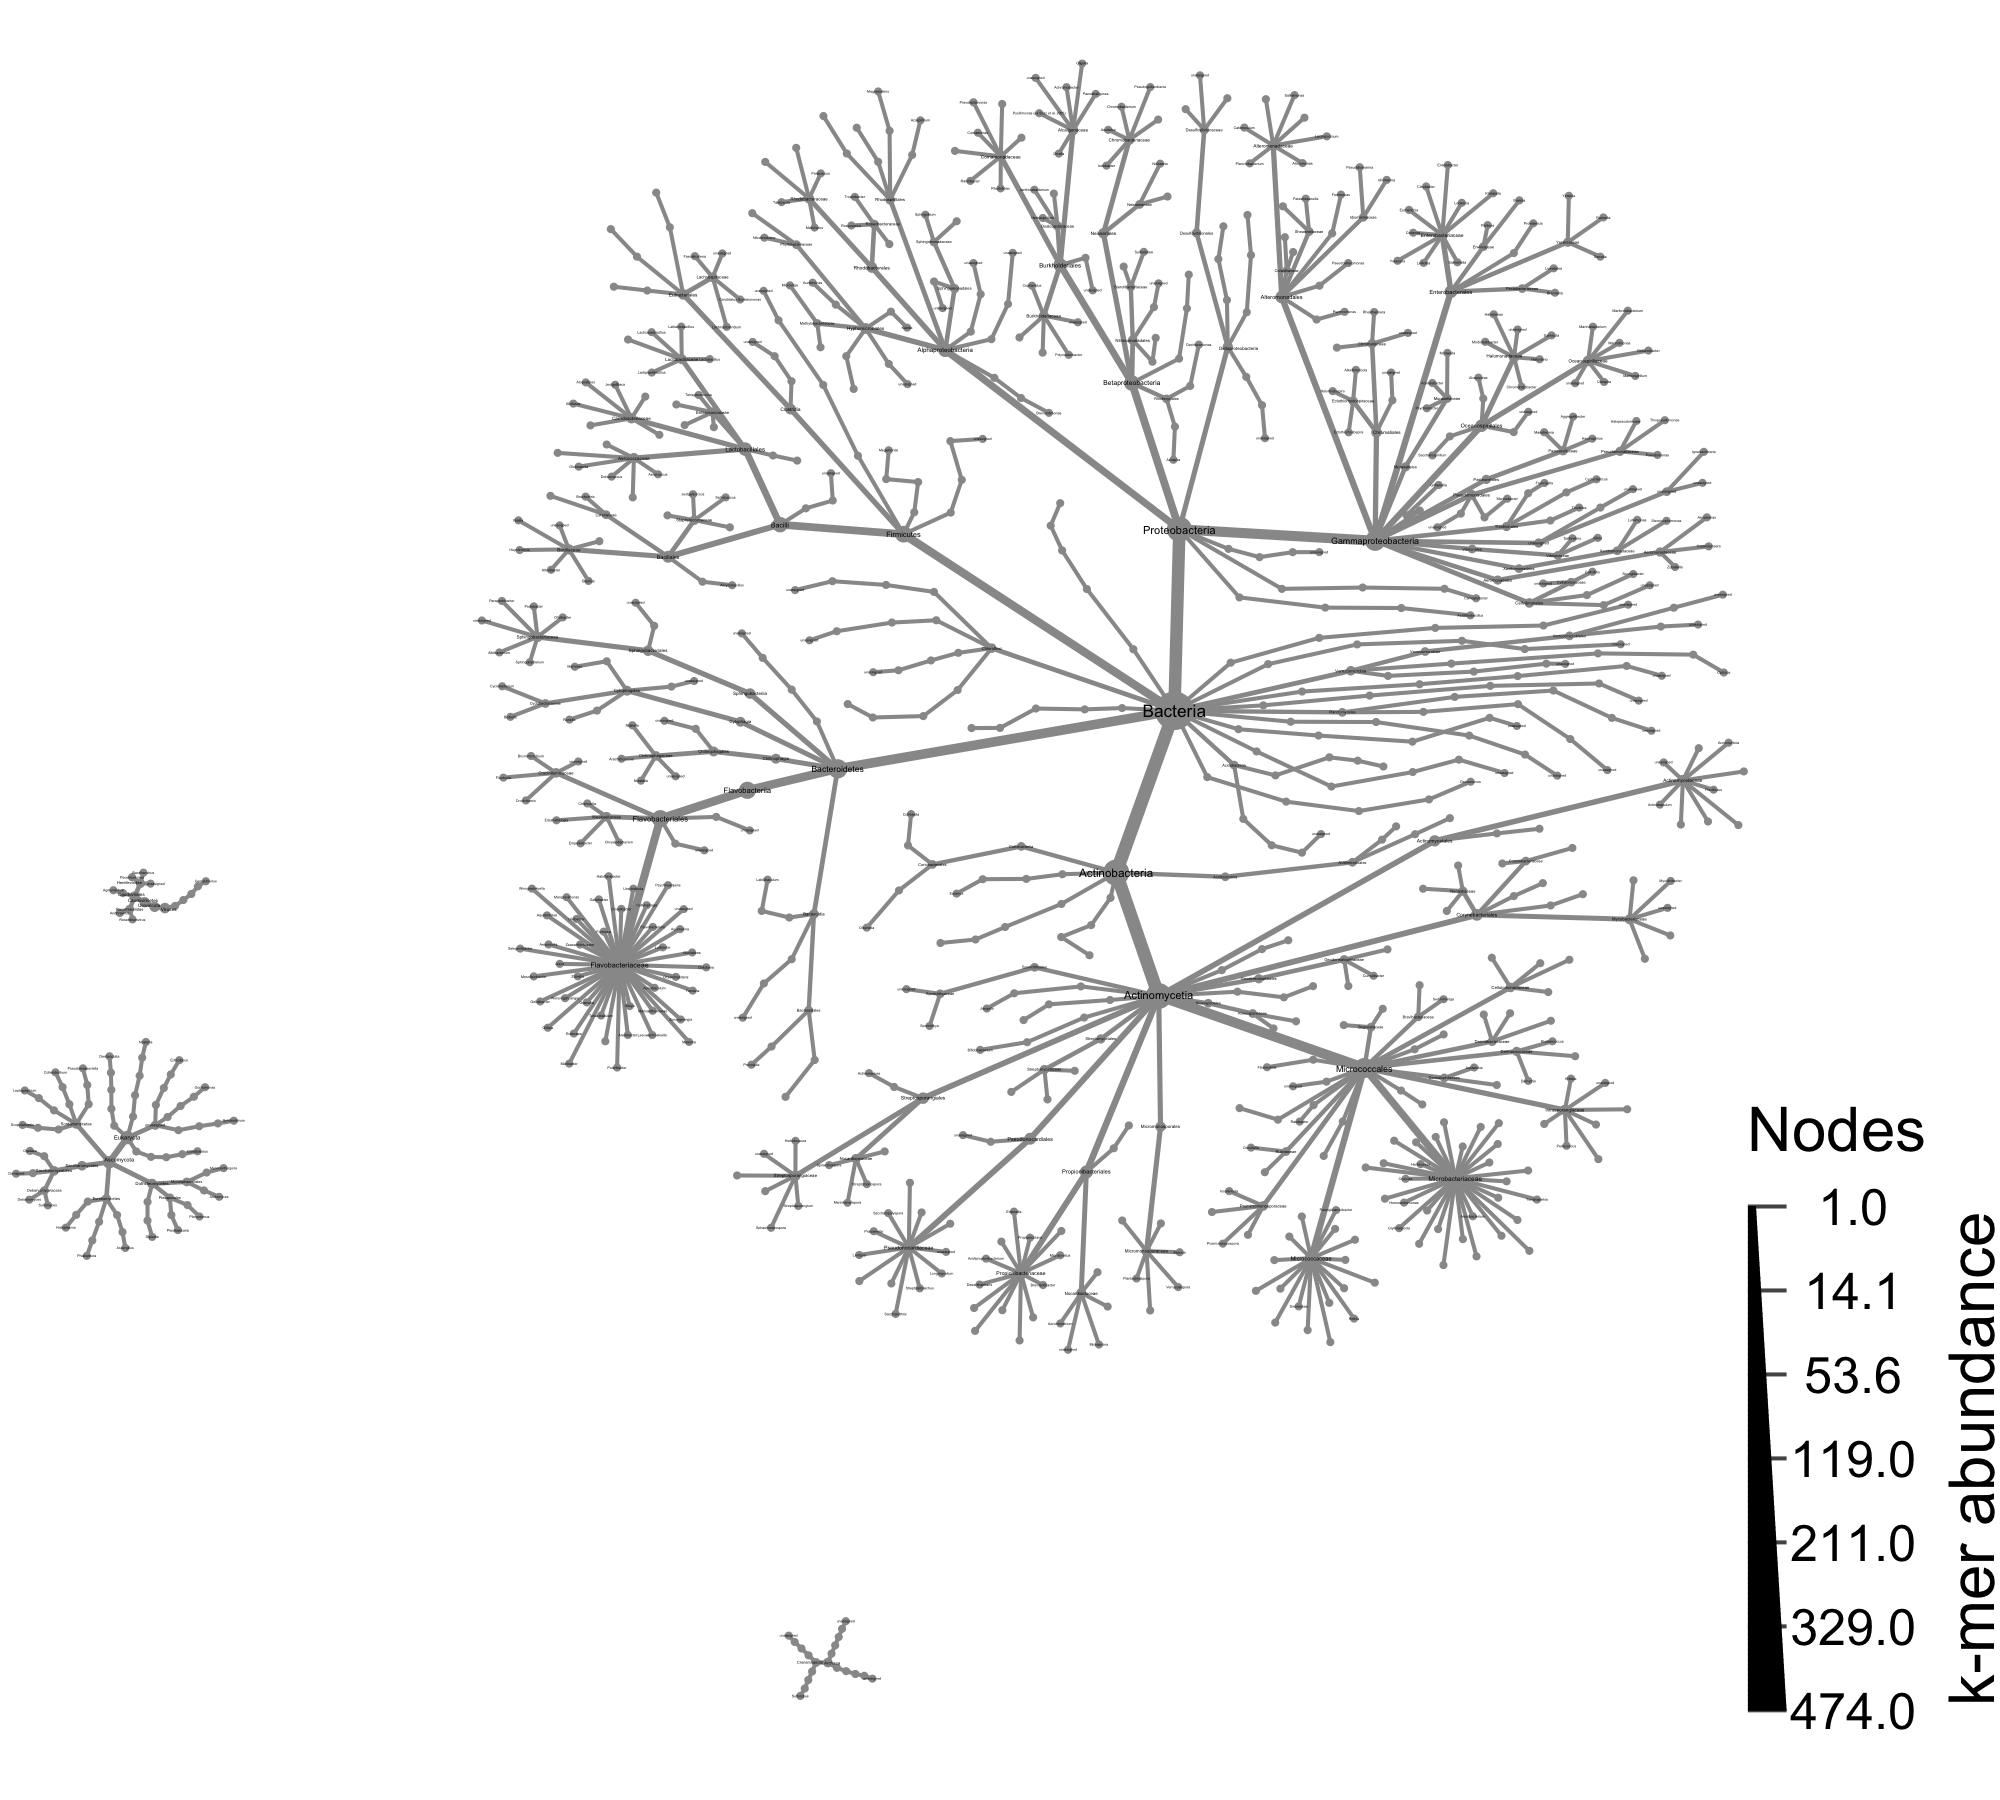

In [16]:
heat_tree(obj_genus, 
          node_label = taxon_names,
          node_size = n_obs,
          node_size_axis_label = "k-mer abundance",
          output_file = "metacoder_genus.pdf", # uncomment to save file upon running
          layout = "davidson-harel", # The primary layout algorithm
          initial_layout = "reingold-tilford") # The layout algorithm that initializes node locations